# 20240908 3次関数の回帰分析

[2024年6月15日に作成したPyMCの3次関数推定コード](https://github.com/Tremendous1192/PyMC-Leraning/blob/main/experiments/20240615%203%E6%AC%A1%E9%96%A2%E6%95%B0%E3%81%AE%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90(nutpie).ipynb)をBambiライブラリで書き直した。

所感
* 簡単なモデルの場合、PtMCよりモデル作成が簡単
* PyMCではモデル構造に係数と目的変数が表示されていたが、Bambiでは特徴量と目的変数が書かれている。
    * Bambiのほうが目的変数と係数との関係がわかりやすい
* nutpie サンプラーも使用できる
* 推定値の誤差の確率分布はスチューデントのt分布を想定している
    * 推定値のばらつきが小さい

## 準備

ライブラリインポート

In [1]:
import arviz as az
import numpy as np
#import pymc as pm
#import pytensor.tensor as pt
#import nutpie
import bambi as bmb
#import statsmodels.api as sm

import polars as pl

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

In [2]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

今回も,$y = \frac{x^3}{3} - x$に正規分布のノイズを加えたデータセットの回帰問題に挑戦します.\
ただし,データ数は20個に減らします.

データの分布を図1に示します.

(-3.0, 3.0)

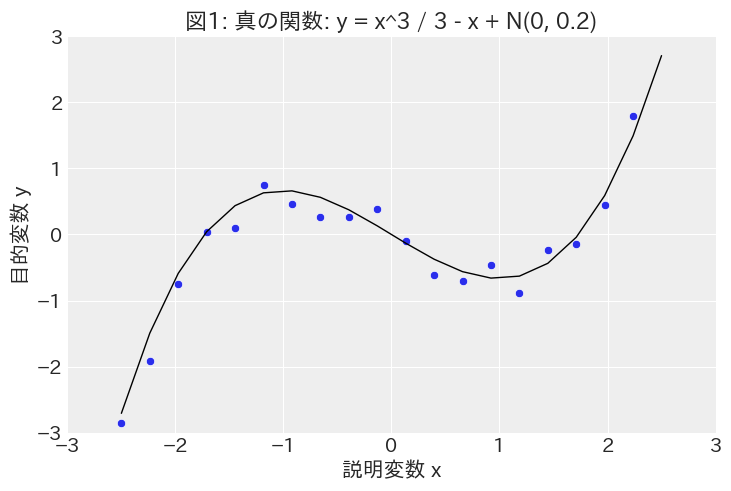

In [3]:
x = np.linspace(-2.5, +2.5, 20)
noise = np.random.normal(loc = 0.0, scale = 0.2, size = x.shape[0])
y = x ** 3 / 3.0 - x + noise


plt.plot(x, y - noise, linewidth = 1, alpha = 1, c = "black")
sns.scatterplot(x = x, y = y)

plt.title("図1: 真の関数: y = x^3 / 3 - x + N(0, 0.2)")
plt.xlabel("説明変数 x")
plt.ylabel("目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

$x < 1$のデータを訓練データセット, $x \geq 1$のデータをテストデータセットとします.\
今回の問題は,$x < 1$のデータを用いて,$x \geq 1$の目的変数を予測することとなります.

図2は訓練データセットの散布図です.\
切り取られた右端のデータセットを予測することが,今回の課題になります.

(-3.0, 3.0)

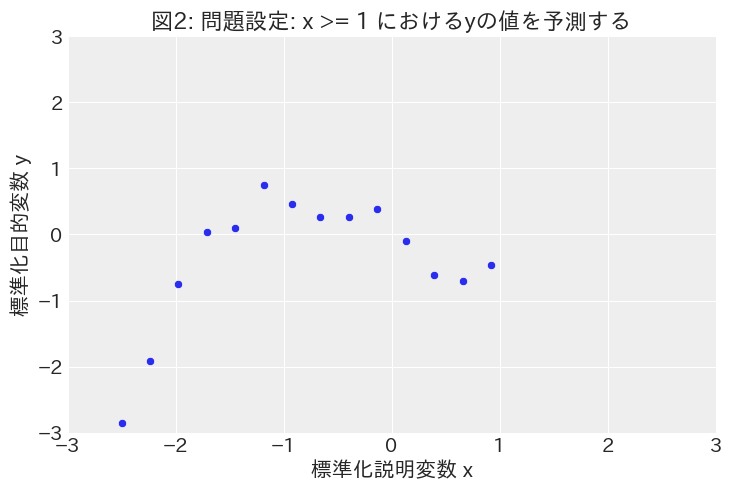

In [4]:
x_train, x_test = x[ x < 1 ], x[ x >= 1]
y_train, y_test = y[ x < 1 ], y[ x >= 1]

sns.scatterplot(x = x_train, y = y_train)
plt.title("図2: 問題設定: x >= 1 におけるyの値を予測する")
plt.xlabel("標準化説明変数 x")
plt.ylabel("標準化目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

## モデル定義

タイトルに答えが書いてありますが,一応3次関数でモデルを作成する理由を書いておきましょう.

1. 散布図のピークが1つだけ見えるので,2次関数か3次関数で近似するのが無難.
1. 標準化したデータの散布図が線対称ではないので,3次関数を選択する.
    * $x = -3, 1$の目的変数の値が倍以上異なる.

したがって,今回の確率モデルは下記の式で表されます.
$$
\begin{align}
y &\sim \mathcal{N} \bigl( \mu , \sigma ^2 \bigr)\\
\mu &= \beta _0 + \beta _1 x + \beta _2 x^2 + \beta _3 x^3\\
\sigma &\sim \mathcal{HN} \bigl(1)\\
\beta _i &\sim \mathcal{N} \bigl( 0 , 1)
\end{align}
$$

ここで,$\alpha$は3次関数の切片,$\beta _i$は係数です.
$\alpha$と$\beta _i$は標準正規分布,$\sigma$標準半正規分布と仮定します(事前分布).
この確率モデルをプログラミングすると,次のセルの通りになります.

In [5]:
# Bambi のモデルを構築できるようにPanda DataFrame に変換する
train = pl.DataFrame({
    "y": y_train,
    "x": x_train,
    "x2": x_train * x_train,
    "x3": x_train * x_train * x_train,
}).to_pandas()

test = pl.DataFrame({
    "y": y_test,
    "x": x_test,
    "x2": x_test * x_test,
    "x3": x_test * x_test * x_test,
}).to_pandas()

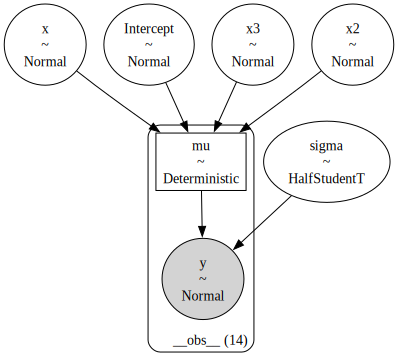

In [6]:
# モデル定義
model = bmb.Model("y ~ x + x2 + x3", train)
model.build()

# モデル構造の可視化
model.graph()

## 事後分布の生成

モデル構造が設計どおりであることを確認したら,次はMCMCに基づく事後分布の生成を行います.

In [7]:
idata = model.fit(draws = 1000, tune = 1000, chains = 2, target_accept = 0.90, random_seed = rng, nuts_sampler = "nutpie")

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:303: UserWarning: `var_names` are currently ignored by the nutpie sampler
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.31,15
,2000,0,0.27,7


サンプリングトレースが問題ないことを確認したら,モデルの評価に移ります.

判断基準
* 左側の分布が1箇所に収束している.
    * ただし,予測値$\mu$の分布は無視する.
* 右側の分布に黒い縦線(発散)が無い.

In [8]:
#サンプリング結果の確認
#az.summary(idata)

array([[<Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x3'}>]],
      dtype=object)

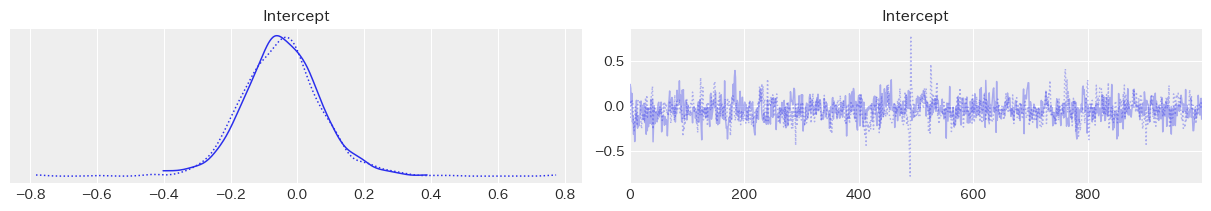

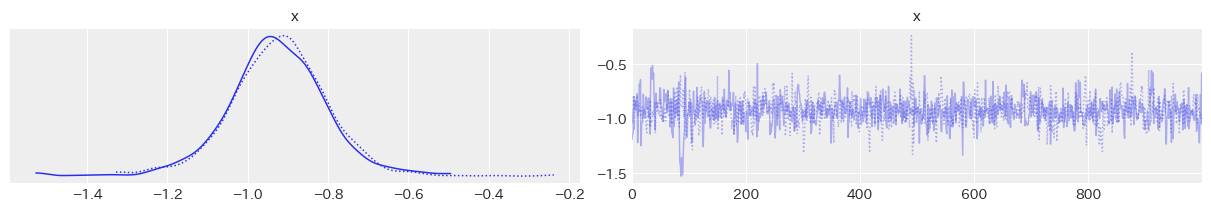

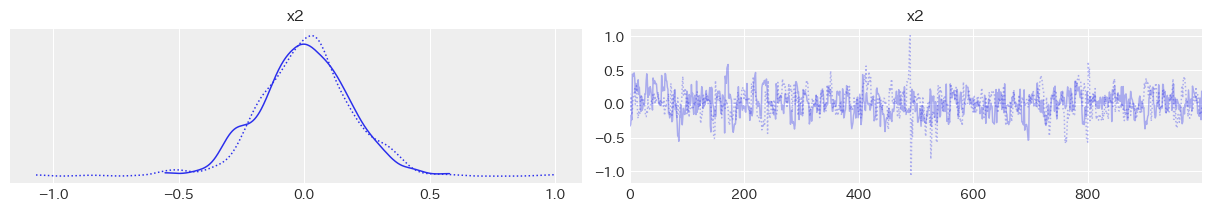

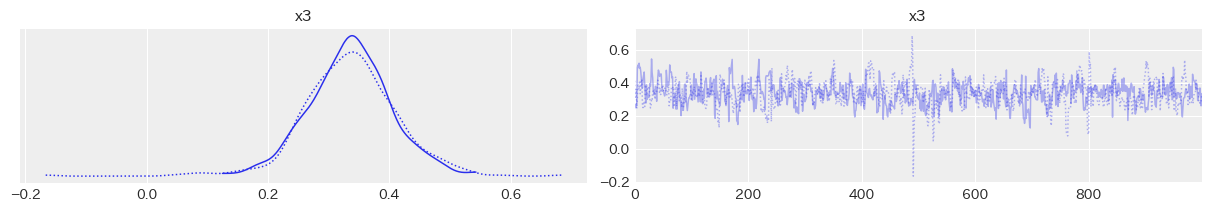

In [9]:
# サンプリングトレースの可視化
az.plot_trace(idata, var_names = ["Intercept"])
az.plot_trace(idata, var_names = ["x"])
az.plot_trace(idata, var_names = ["x2"])
az.plot_trace(idata, var_names = ["x3"])

## モデルの評価

パラメータ推定値の分布から,モデルを評価します.

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

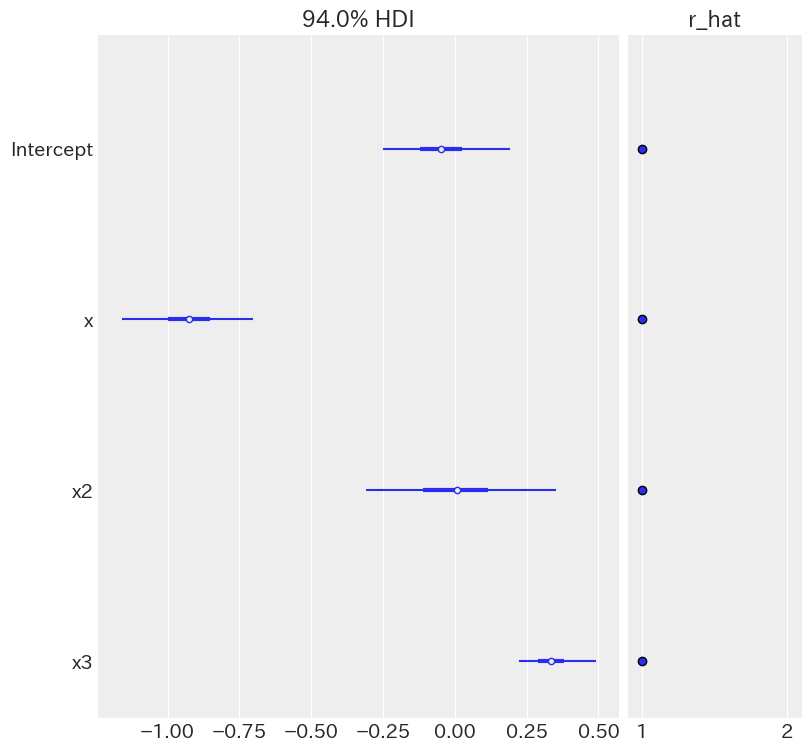

In [10]:
az.plot_forest(idata, combined = True, var_names = ["Intercept", "x", "x2", "x3"], r_hat = True)

```r_hat```が1に近いとパラメータ推定は安定していると考えられます.

また,パラメータ推定値は真の関数$y = \frac{x^3}{3} - x$の係数とほぼ同じ値を指しました.

## データの予測

テストデータの予測値を算出します

In [11]:
# 係数
# 描画時間短縮のため,サンプリングの終盤の20個で予測する
beta_0 = idata["posterior"]["Intercept"].values.reshape(-1, 1)[-20:]
beta_1 = idata["posterior"]["x"].values.reshape(-1, 1)[-20:]
beta_2 = idata["posterior"]["x2"].values.reshape(-1, 1)[-20:]
beta_3 = idata["posterior"]["x3"].values.reshape(-1, 1)[-20:]

# 予測値分布
y_preds = (
    beta_0 * np.ones(len(x))
    + beta_1 * x
    + beta_2 * x ** 2
    + beta_3 * x ** 3
)

テストデータの予測値をプロットします.

(-3.0, 3.0)

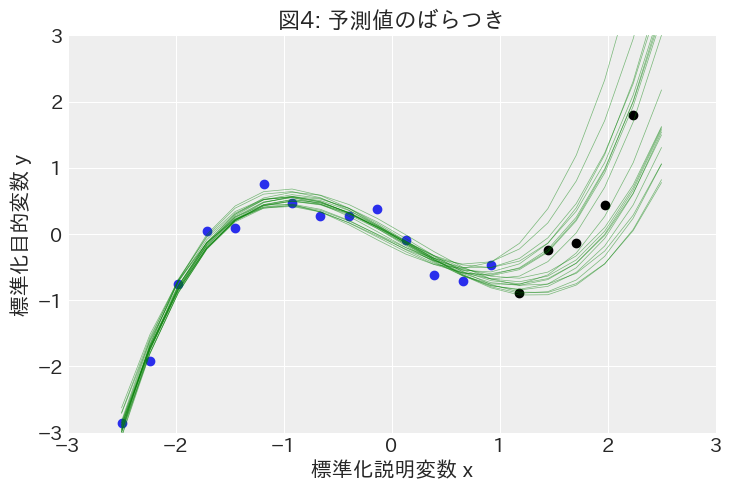

In [12]:
_, ax = plt.subplots()

# 予測分布
for y_pred in y_preds:
    plt.plot(x, y_pred, linewidth = 0.5, alpha = 0.5, c = "green")

# 訓練データ
ax.scatter(x_train, y_train)
ax.scatter(x_test, y_test, marker = "o", color = "k")

ax.set_title("図4: 予測値のばらつき")
ax.set_xlabel("標準化説明変数 x")
ax.set_ylabel("標準化目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)